### Лабораторная работа 4. Регрессия

#### Задачи:
Попробовать методы регрессии на своих наборах данных.
Работа будет засчитана, если коэффициент детерминации будет не меньше, чем 0.85.
Чтобы достигнуть этой метрики вам понадобится:
1. загрузить данные
1. проанализировать их
1. предобработать данные
1. попробовать разные методы регрессии
1. получить метрики
1. визуализировать регрессию на одном из параметров



In [267]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes  # подключаем датасет из sklearn
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

#from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter


#### Описание датасета:
Для анализа используется датасет "taxi_trip_pricing", созданный для прогнозирования цен на поездки на такси методом регрессии.
- **Trip_Distance_km:** длина поездки.
- **Time_of_Day:** время суток во время поездки.
- **Day_of_Week:** категориальный индикатор дня недели (будни, выходные).
- **Passenger_Count:** количество пассажиров в поездке.
- **Traffic_Conditions:** категориальный индикатор трафика (легкий, средний, интенсивный).
- **Weather:** категориальные данные о погоде (ясно, дождь, снег).
- **Base_Fare:** Первоначальная базовая стоимость поездки на такси без учета расходов на расстояние или время.
- **Per_Km_Rate:** Тариф взимаемый за километр поездки.
- **Per_Minute_Rate:** Тариф взимаемый за минуту поездки.
- **Pickup Time:** время начала поездки.
- **Dropoff Time:** время окончания поездки.
- **Trip_Duration_Minutes:** общее время поездки.
- **Trip_Price:** стоимость поездки (в долларах США).


In [268]:
df = pd.read_csv('taxi_trip_pricing.csv')
df.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180


#### Общие статистические данные

Размер датасета

In [269]:
df.shape

(1000, 11)

Проверим на пропуски

In [270]:
df.isnull().sum()

Trip_Distance_km         50
Time_of_Day              50
Day_of_Week              50
Passenger_Count          50
Traffic_Conditions       50
Weather                  50
Base_Fare                50
Per_Km_Rate              50
Per_Minute_Rate          50
Trip_Duration_Minutes    50
Trip_Price               49
dtype: int64

Обнаружены пропуски! Посмотрим на средние и медианы данных

Trip_Distance_km - Среднее: 27.070546861761322, Медиана: 25.83


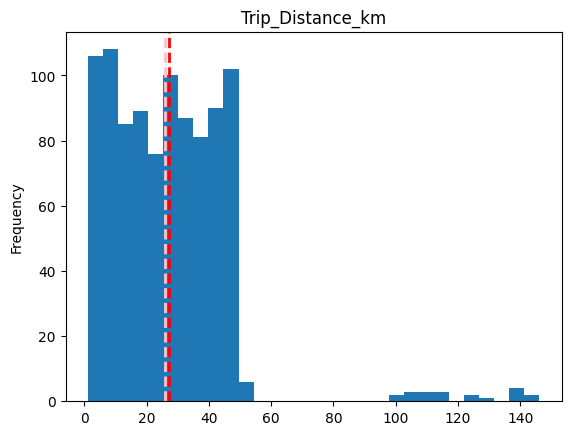

Passenger_Count - Среднее: 2.4768421052631577, Медиана: 2.0


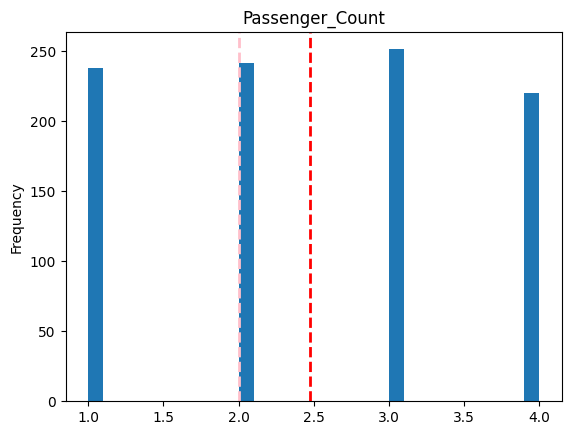

Base_Fare - Среднее: 3.502989473684211, Медиана: 3.52


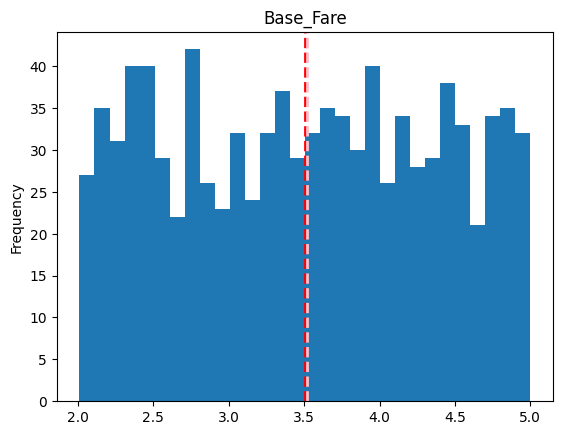

Per_Km_Rate - Среднее: 1.2333157894736844, Медиана: 1.22


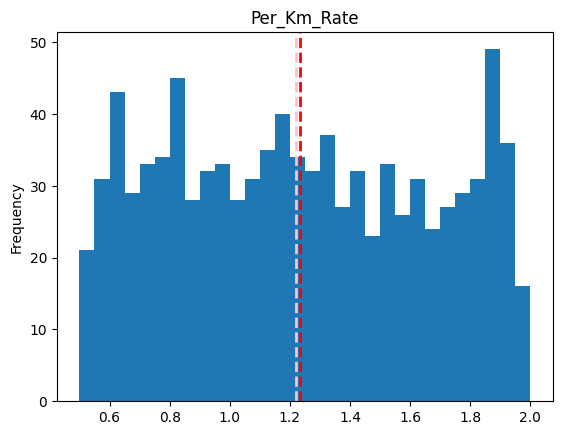

Per_Minute_Rate - Среднее: 0.2929157894736842, Медиана: 0.29


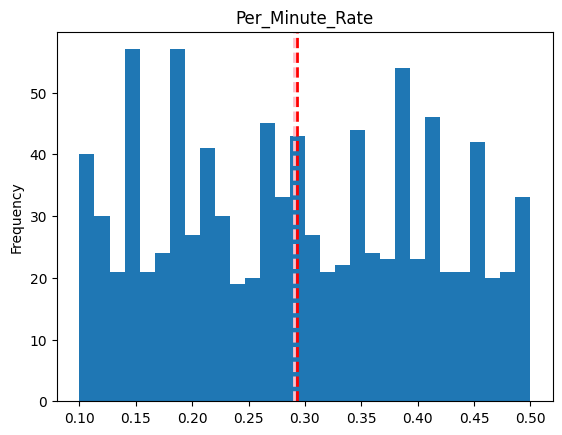

Trip_Duration_Minutes - Среднее: 62.11811578947369, Медиана: 61.86


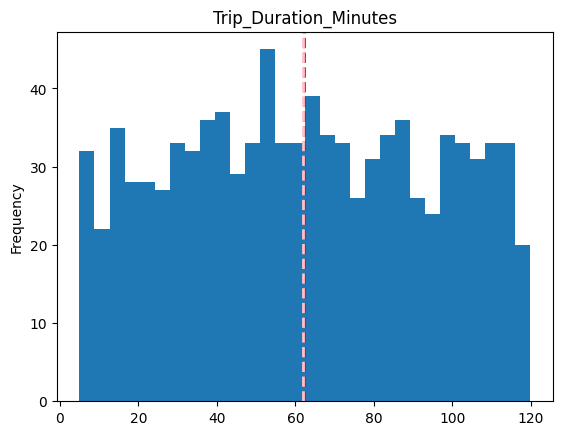

Trip_Price - Среднее: 56.87477332571041, Медиана: 50.07450000000001


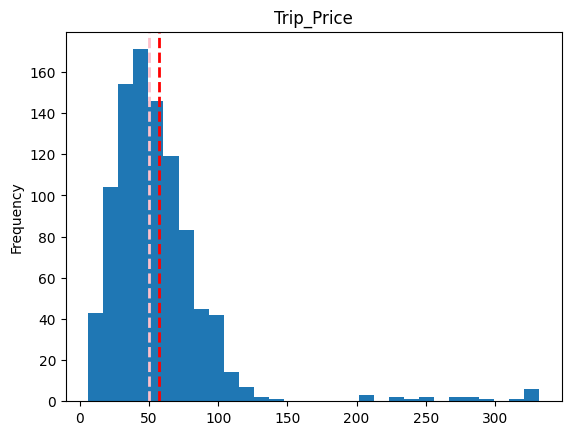

(1000, 11)

In [271]:
columns_with_missing = ['Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 'Per_Km_Rate',
                       'Per_Minute_Rate', 'Trip_Duration_Minutes',
                       'Trip_Price']

for i in columns_with_missing:
    print(f"{i} - Среднее: {df[i].mean()}, Медиана: {df[i].median()}")
    df[i].plot(kind='hist', bins=30, title=i)
    plt.axvline(df[i].mean(), color='red', linestyle='dashed', linewidth=2)
    plt.axvline(df[i].median(), color='pink', linestyle='dashed', linewidth=2)
    plt.show()
df.shape

Устраним пропуски в числовых полях медианными значениями

In [272]:
df['Trip_Distance_km'].fillna(df['Trip_Distance_km'].median(), inplace=True)
df['Passenger_Count'].fillna(df['Passenger_Count'].median(), inplace=True)
df['Base_Fare'].fillna(df['Base_Fare'].median(), inplace=True)
df['Per_Km_Rate'].fillna(df['Per_Km_Rate'].median(), inplace=True)
df['Per_Minute_Rate'].fillna(df['Per_Minute_Rate'].median(), inplace=True)
df['Trip_Duration_Minutes'].fillna(df['Trip_Duration_Minutes'].median(), inplace=True)
df['Trip_Price'].fillna(df['Trip_Price'].median(), inplace=True)
df.isnull().sum()


Trip_Distance_km          0
Time_of_Day              50
Day_of_Week              50
Passenger_Count           0
Traffic_Conditions       50
Weather                  50
Base_Fare                 0
Per_Km_Rate               0
Per_Minute_Rate           0
Trip_Duration_Minutes     0
Trip_Price                0
dtype: int64

Информация о столбцах и типах данных в них

In [273]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       1000 non-null   float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        1000 non-null   float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              1000 non-null   float64
 7   Per_Km_Rate            1000 non-null   float64
 8   Per_Minute_Rate        1000 non-null   float64
 9   Trip_Duration_Minutes  1000 non-null   float64
 10  Trip_Price             1000 non-null   float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB


In [274]:
df.describe()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,27.008520,2.453000,3.503840,1.232650,0.292770,62.105210,56.541560
std,19.402661,1.079331,0.848115,0.418932,0.112664,31.339464,39.492129
min,1.230000,1.000000,2.010000,0.500000,0.100000,5.010000,6.126900
25%,13.107500,2.000000,2.770000,0.870000,0.197500,37.107500,34.578850
50%,25.830000,2.000000,3.520000,1.220000,0.290000,61.860000,50.074500
75%,37.782500,3.000000,4.202500,1.580000,0.382500,87.775000,67.476650
max,146.067047,4.000000,5.000000,2.000000,0.500000,119.840000,332.043689


In [275]:
df.describe(include='object')

,Time_of_Day,Day_of_Week,Traffic_Conditions,Weather
count,950,950,950,950
unique,4,2,3,3
top,Afternoon,Weekday,Low,Clear
freq,371,655,397,667


Проверим категориальные данные на допустимые значения

In [276]:
df['Time_of_Day'].unique()


array(['Morning', 'Afternoon', 'Evening', 'Night', nan], dtype=object)

In [277]:
df['Day_of_Week'].unique()


array(['Weekday', 'Weekend', nan], dtype=object)

In [278]:
df['Traffic_Conditions'].unique()


array(['Low', 'High', 'Medium', nan], dtype=object)

In [279]:
df['Weather'].unique()


array(['Clear', nan, 'Rain', 'Snow'], dtype=object)

Присутствуют nan. Удалим данные с ними (на всякий случай)

In [280]:
df.dropna(inplace=True)
df.shape

(811, 11)

Пострадал размер, но этого ещё достаточно. Едем дальше

Функция для вычисления метрик

In [281]:
def Reg_Models_Evaluation_Metrics (model,X_train,y_train,X_test,y_test,y_pred):
    cv_score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)

    # Calculating Adjusted R-squared
    r2 = model.score(X_test, y_test)
    # Number of observations is the shape along axis 0
    n = X_test.shape[0]
    # Number of features (predictors, p) is the shape along axis 1
    p = X_test.shape[1]
    # Adjusted R-squared formula
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    R2 = model.score(X_test, y_test)
    CV_R2 = cv_score.mean()

    print(f'RMSE:  {round(RMSE,4)}\n  R2: {round(R2,4)}\n Adjusted R2: {round(adjusted_r2, 4)}\n Cross Validated R2: {round(cv_score.mean(),4)}')
    return R2, adjusted_r2, CV_R2, RMSE

Есть хорошие корелляции!

Построим диаграммы рассеивания

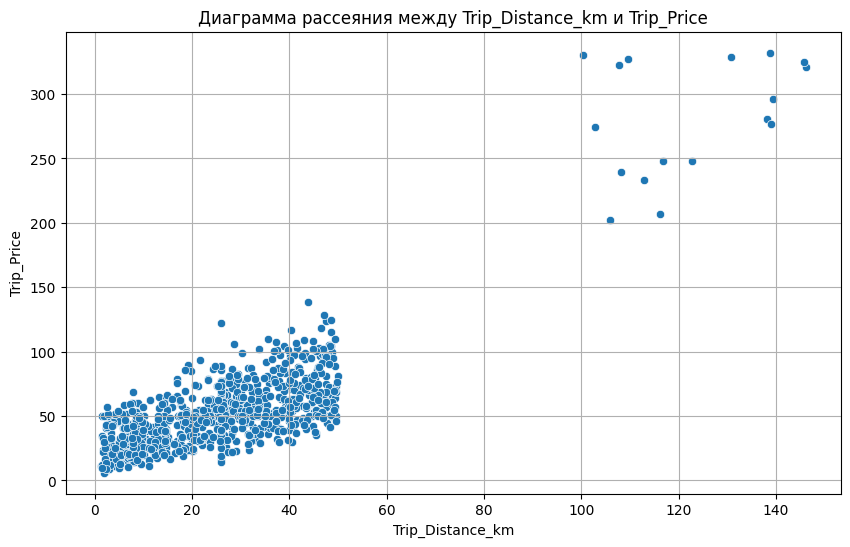

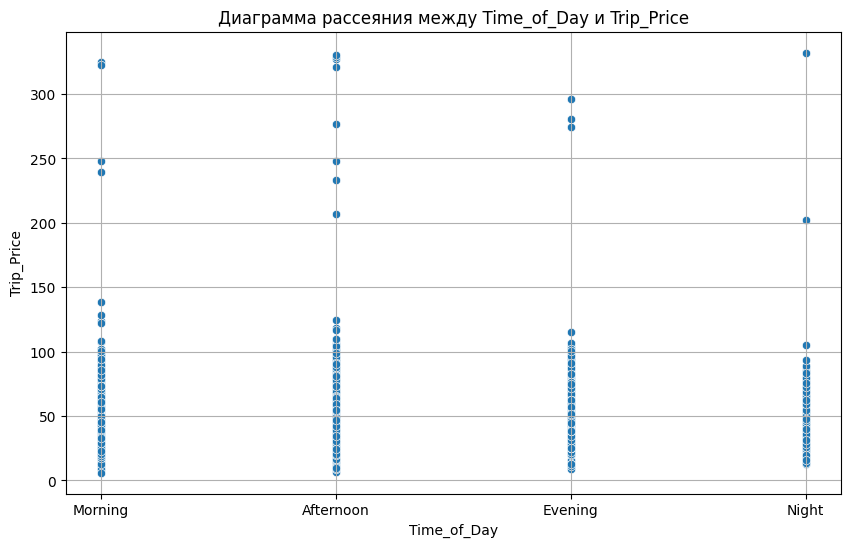

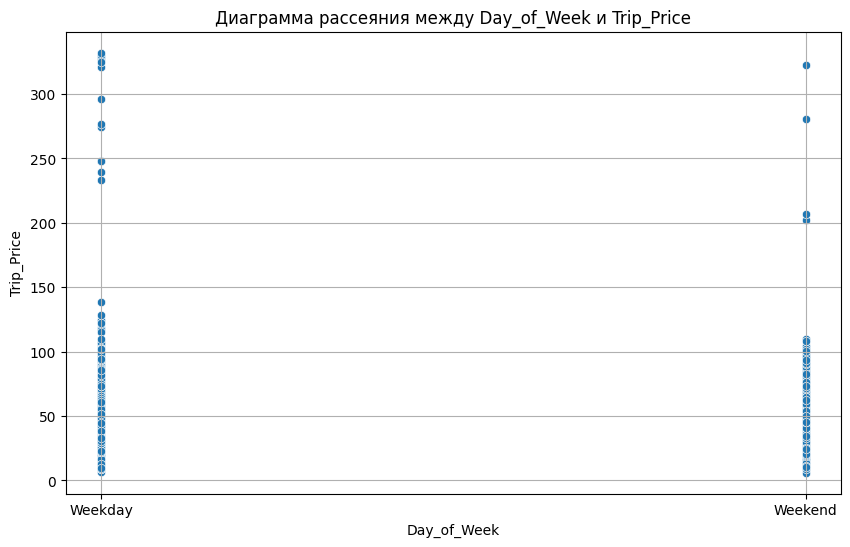

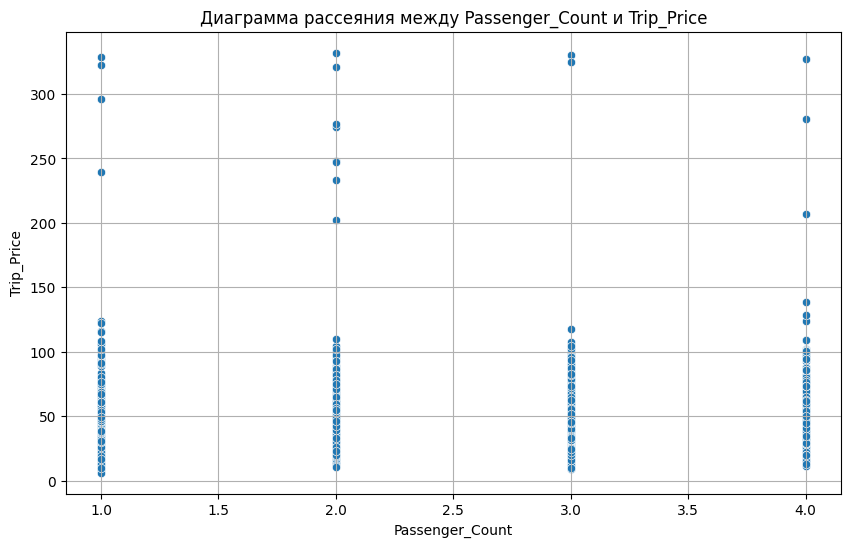

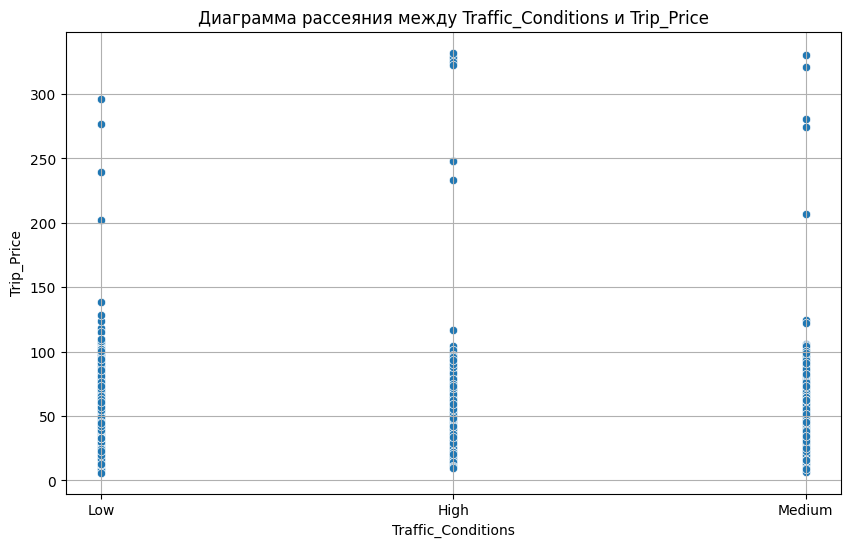

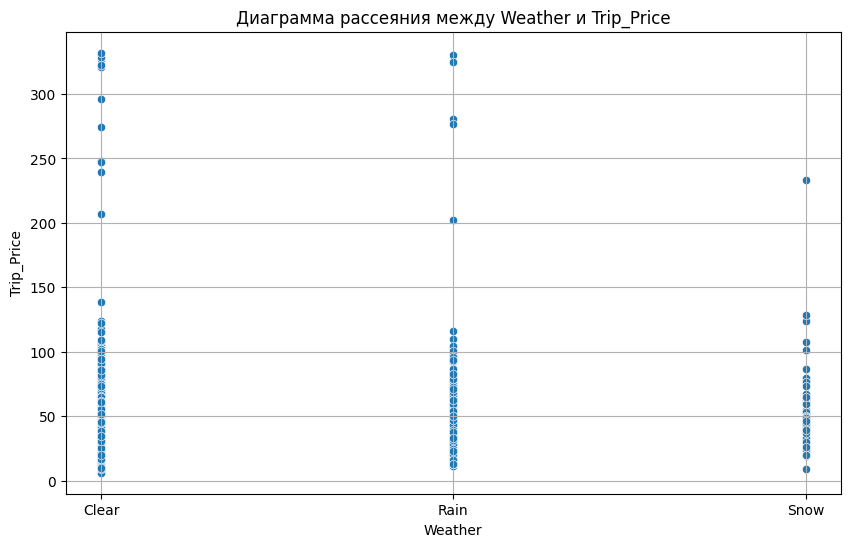

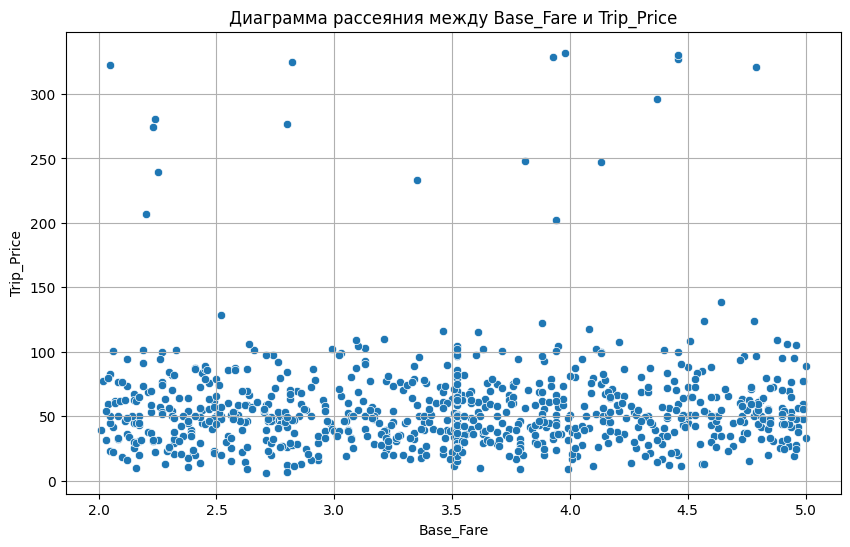

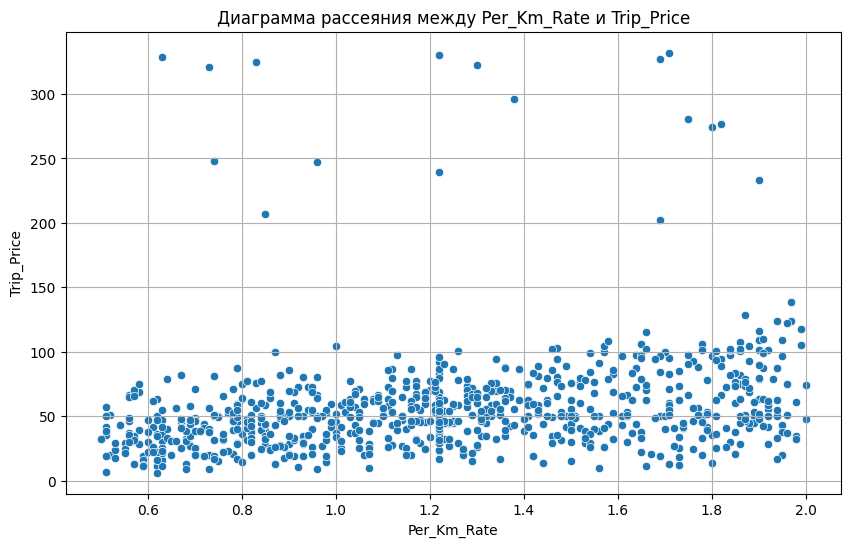

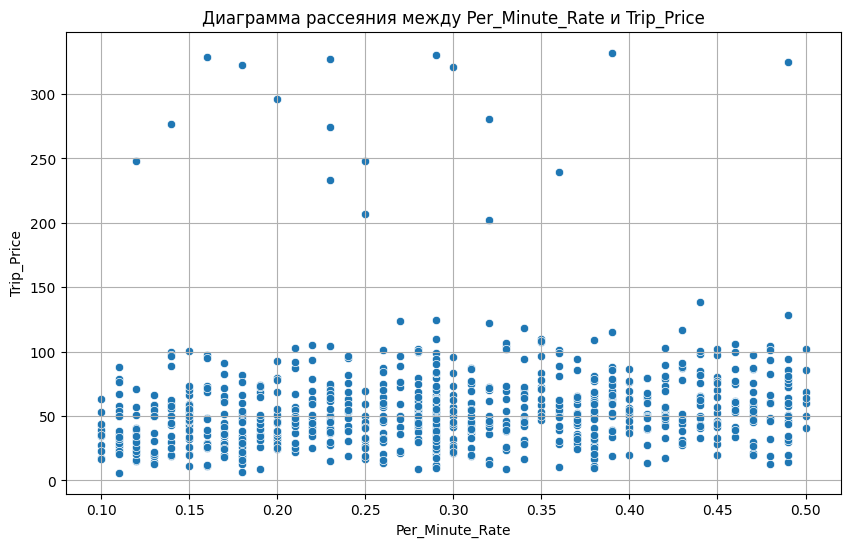

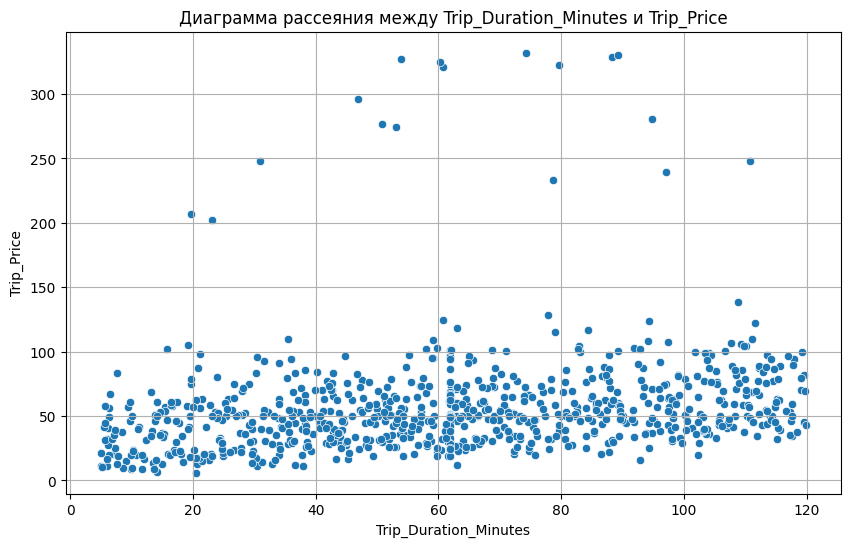

In [282]:
def scatter_plot(df, feature, target):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=feature, y=target)
    plt.title(f'Диаграмма рассеяния между {feature} и {target}')
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.grid()
    plt.show()

features = list(df.columns[:-1])
target = 'Trip_Price'

for feature in features:
    scatter_plot(df, feature, target)

Работа с категориальными данными

Пока заменим их через OrdinalEncoder

In [283]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
df[['Weather', 'Time_of_Day', 'Day_of_Week', 'Traffic_Conditions']] = enc.fit_transform(df[['Weather', 'Time_of_Day', 'Day_of_Week', 'Traffic_Conditions']])
df.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,2.0,0.0,3.0,1.0,0.0,3.56,0.80,0.32,53.82,36.2624
1,47.59,0.0,0.0,1.0,0.0,0.0,3.52,0.62,0.43,40.57,50.0745
2,36.87,1.0,1.0,1.0,0.0,0.0,2.70,1.21,0.15,37.27,52.9032
4,25.83,1.0,0.0,3.0,0.0,0.0,2.93,0.63,0.32,22.64,15.6180
5,8.64,0.0,1.0,2.0,2.0,0.0,2.55,1.71,0.48,89.33,60.2028


Посмотрим на температурную карту

<Axes: >

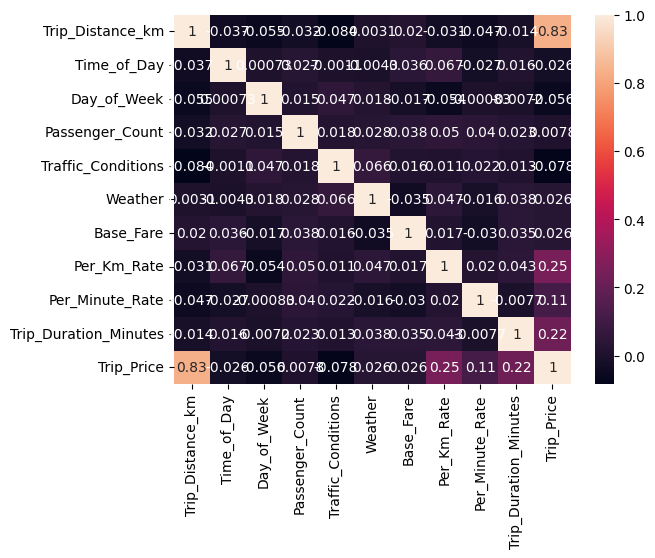

In [284]:
sns.heatmap(df.corr(numeric_only = True), annot=True)

Возьмём только числовые, т.к. по предварительному анализу нет хороших корелляций между ценой и категориальными данными

<Axes: >

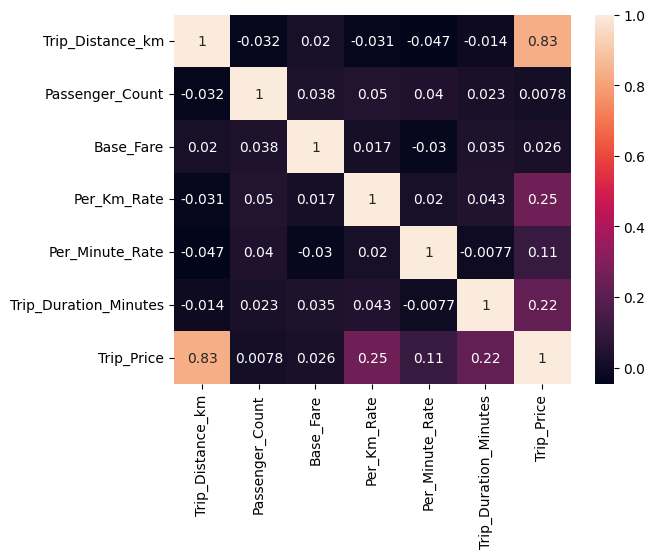

In [285]:
df.drop(columns=['Weather', 'Time_of_Day', 'Day_of_Week', 'Traffic_Conditions'], inplace=True)
sns.heatmap(df.corr(numeric_only = True), annot=True)

Так то лучше. Подготовим датасет к обучению

In [286]:
X = df.drop(['Trip_Price'], axis=1)
y = df['Trip_Price']
print(f'X shape: {X.shape} | y shape: {y.shape} ')

X shape: (811, 6) | y shape: (811,) 


### Обучение

#### Линейная регрессия

In [287]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=29)
from sklearn.linear_model import LinearRegression
modelLR = LinearRegression()
modelLR.fit(X_train, y_train)
y_pr_LR = modelLR.predict(X_test)

_ = Reg_Models_Evaluation_Metrics(modelLR, X_train, y_train, X_test, y_test, y_pr_LR)

RMSE:  18.6173
  R2: 0.8283
 Adjusted R2: 0.8217
 Cross Validated R2: 0.8241


Нарисуем регрессию от дистанции поездки

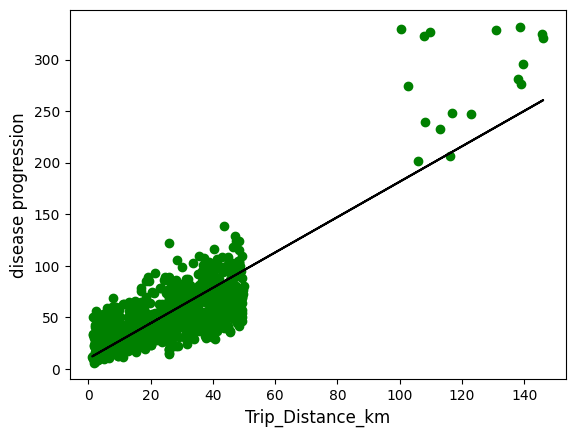

In [288]:
X2 = df['Trip_Distance_km'].values[:,np.newaxis]
# target data is array of shape (n,)
y2 = df['Trip_Price'].values


model2 = LinearRegression()
model2.fit(X2, y2)

plt.scatter(X2, y2,color='g')
plt.plot(X2, model2.predict(X2),color='k')
plt.ylabel('disease progression', size=12)
plt.xlabel('Trip_Distance_km', size=12)
plt.show()

#### Полиномиальная регрессия

In [289]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(X)
X_p_train, X_p_test, y_p_train, y_p_test = train_test_split(poly_features, y, test_size=0.2, random_state=42)

modelPR = LinearRegression()
modelPR.fit(X_p_train, y_p_train)
y_pr_PR = modelPR.predict(X_p_test)
_ = Reg_Models_Evaluation_Metrics(modelPR, X_p_train, y_p_train, X_p_test, y_p_test, y_pr_PR)

RMSE:  11.8479
  R2: 0.908
 Adjusted R2: 0.8113
 Cross Validated R2: 0.7134


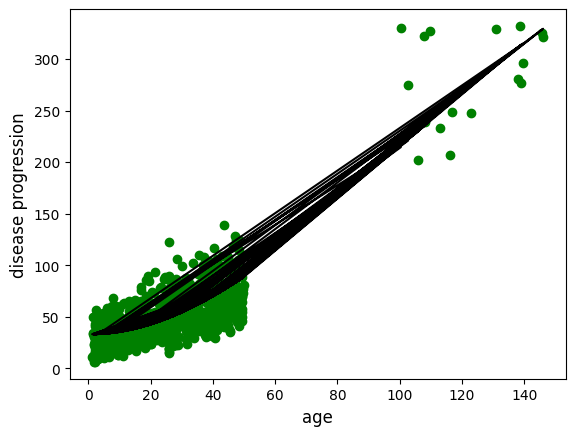

In [290]:
X2 = df['Trip_Distance_km'].values[:,np.newaxis]
y2 = df['Trip_Price'].values

poly_features = poly.fit_transform(X2)

model2 = LinearRegression()
model2.fit(poly_features, y2)


plt.scatter(X2, y2,color='g')
plt.plot(X2, model2.predict(poly.fit_transform(X2)),color='k')
plt.ylabel('disease progression', size=12)
plt.xlabel('age', size=12)
plt.show()

#### Регрессия дерева принятия решений

In [291]:
from sklearn.tree import DecisionTreeRegressor
modelDT = DecisionTreeRegressor()
modelDT.fit(X_train, y_train)
y_dt_pred = modelDT.predict(X_test)
_ = Reg_Models_Evaluation_Metrics(modelDT, X_train, y_train, X_test, y_test, y_dt_pred)

RMSE:  17.9902
  R2: 0.8397
 Adjusted R2: 0.8335
 Cross Validated R2: 0.8054


#### Регрессия случайного леса

In [292]:
from sklearn.ensemble import RandomForestRegressor
modelRF = RandomForestRegressor(n_estimators=100)
modelRF.fit(X_train, y_train)
y_rf_pred = modelRF.predict(X_test)
_ = Reg_Models_Evaluation_Metrics(modelRF, X_train, y_train, X_test, y_test, y_rf_pred)

RMSE:  11.1457
  R2: 0.9385
 Adjusted R2: 0.9361
 Cross Validated R2: 0.9069


#### Регрессия опорных векторов (SVR)

In [293]:
from sklearn.svm import SVR
modelSVR = SVR(kernel='linear')
modelSVR.fit(X_train, y_train)
y_rf_pred = modelSVR.predict(X_test)
_ = Reg_Models_Evaluation_Metrics(modelSVR, X_train, y_train, X_test, y_test, y_rf_pred)

RMSE:  22.2417
  R2: 0.7549
 Adjusted R2: 0.7455
 Cross Validated R2: 0.7858


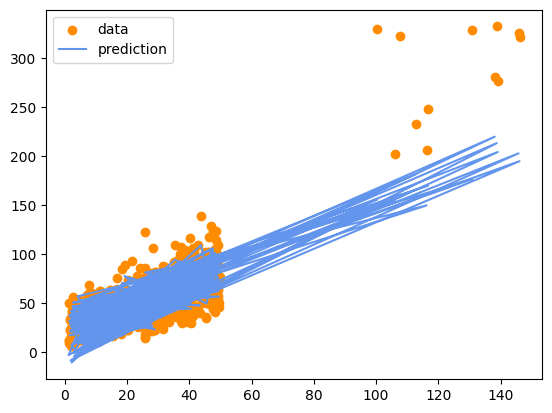

In [294]:
plt.scatter(X_train['Trip_Distance_km'], y_train, color='darkorange',
            label='data')
plt.plot(X_train['Trip_Distance_km'], modelSVR.predict(X_train), color='cornflowerblue',
         label='prediction')
plt.legend()
plt.show()

In [295]:
from sklearn.svm import SVR
modelSVR = SVR(kernel='poly')
modelSVR.fit(X_train, y_train)
y_rf_pred = modelSVR.predict(X_test)
_ = Reg_Models_Evaluation_Metrics(modelSVR, X_train, y_train, X_test, y_test, y_rf_pred)

RMSE:  23.9541
  R2: 0.7157
 Adjusted R2: 0.7048
 Cross Validated R2: 0.7047


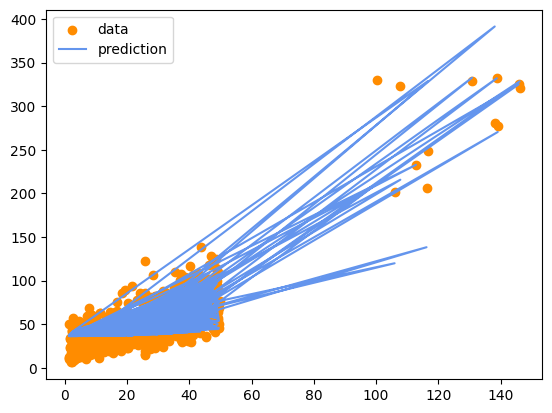

In [296]:
plt.scatter(X_train['Trip_Distance_km'], y_train, color='darkorange',
            label='data')
plt.plot(X_train['Trip_Distance_km'], modelSVR.predict(X_train), color='cornflowerblue',
         label='prediction')
plt.legend()
plt.show()

In [297]:
modelSVR = SVR(kernel='rbf')
modelSVR.fit(X_train, y_train)
y_rf_pred = modelSVR.predict(X_test)
_ = Reg_Models_Evaluation_Metrics(modelSVR, X_train, y_train, X_test, y_test, y_rf_pred)

RMSE:  39.6101
  R2: 0.2227
 Adjusted R2: 0.1928
 Cross Validated R2: 0.2606


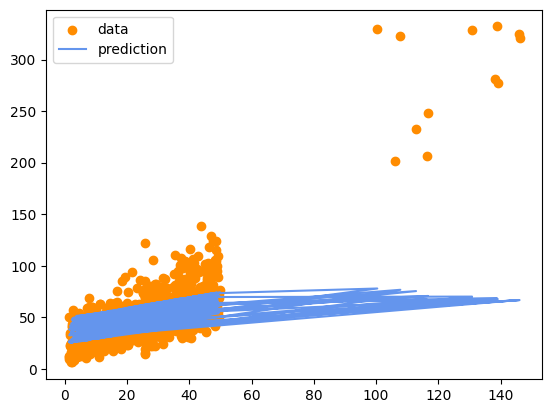

In [298]:
plt.scatter(X_train['Trip_Distance_km'], y_train, color='darkorange',
            label='data')
plt.plot(X_train['Trip_Distance_km'], modelSVR.predict(X_train), color='cornflowerblue',
         label='prediction')
plt.legend()
plt.show()

#### Регрессия ElasticNet

In [299]:
from sklearn.linear_model import ElasticNet
modelEN = ElasticNet(alpha=0.1, l1_ratio=0.8)
modelEN.fit(X_train, y_train)
y_en_pred = modelEN.predict(X_test)
_ = Reg_Models_Evaluation_Metrics(modelEN, X_train, y_train, X_test, y_test, y_en_pred)

RMSE:  18.6923
  R2: 0.8269
 Adjusted R2: 0.8202
 Cross Validated R2: 0.809


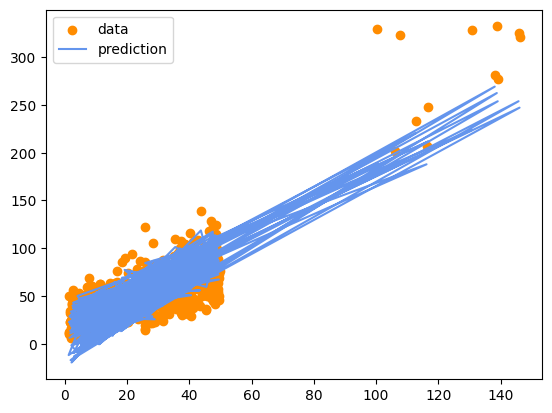

In [300]:
plt.scatter(X_train['Trip_Distance_km'], y_train, color='darkorange',
            label='data')
plt.plot(X_train['Trip_Distance_km'], modelEN.predict(X_train), color='cornflowerblue',
         label='prediction')
plt.legend()
plt.show()

### Вывод
Из всех вариантов регрессий по RMSE наилучшими оказались регрессия случайного леса и полиномиальная регрессия с 3 степенью полиномиальных признаков. При этом, они не сильно лучше обыкновенной линейной регрессии. Сказывается тот фактор, что наибольший кореллят к "Trip_Price", а именно "Trip_Distance_km" показывает окололинейный тренд. А линейную функцию третьим порядком полинома не испортишь). Заявленного коэффициента детерминации удалось добиться на регрессии случайного леса. Возможно, устранение выбросов улучшило бы ситуацию